# Generate a null distribution per well

In [1]:
import os
import sys
import pickle
import random
import pathlib
import numpy as np
import pandas as pd

from scipy import stats
from statistics import median
from collections import defaultdict

from pycytominer import feature_select

sys.path.append("..")
from null_util import get_null_dist_median_scores, get_null_distribution_replicates

In [2]:
np.random.seed(42)

## Define constants

In [3]:
random_permutation_count = 1000
num_unique_sample_cutoff = 20

metadata_cols_to_drop = [
    'Metadata_broad_sample',
    'Metadata_pert_id',
    'Metadata_dose_recode',
    'Metadata_Plate',
    'Metadata_Well',
    'Metadata_broad_id',
    'Metadata_moa',
    'broad_id',
    'pert_iname',
    'moa'
]

cp_level4_path = "cellpainting_lvl4_cpd_replicate_datasets"
cp_file_indicator = ""

output_file = pathlib.Path(
    "results", f"well_controlled_percent_replicating_non_parametric_p_values{cp_file_indicator}.tsv"
)

## Load data

In [4]:
# Load common compounds
common_file = pathlib.Path(
    "..", "..", "..", "6.paper_figures", "data", "significant_compounds_by_threshold_both_assays.tsv.gz"
)
common_df = pd.read_csv(common_file, sep="\t")

common_compounds = common_df.compound.unique()
print(len(common_compounds))

1327


In [5]:
# Load level 4 replicate profiles
df_level4 = pd.read_csv(
    os.path.join(cp_level4_path, f'cp_level4_cpd_replicates{cp_file_indicator}.csv.gz'), 
    compression='gzip',low_memory = False
)

print(df_level4.shape)
df_level4.head(2)

(51833, 812)


,Metadata_broad_sample,Metadata_pert_id,Metadata_Plate,Metadata_Well,Metadata_broad_id,Metadata_moa,Metadata_dose_recode,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,...,Nuclei_Texture_SumVariance_Mito_5_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,broad_id,pert_iname,moa,replicate_name
0,DMSO,NaN,SQ00015211,A01,NaN,NaN,0,2.366133,-0.032317,0.618638,...,-0.571713,0.757513,-0.634580,1.440005,-0.044817,0.264545,DMSO,DMSO,Control vehicle,replicate_0
1,DMSO,NaN,SQ00015211,A02,NaN,NaN,0,0.376276,-1.135014,0.179721,...,-0.177450,-1.684778,-1.235524,1.958443,0.165417,-0.985233,DMSO,DMSO,Control vehicle,replicate_1


In [6]:
# Get treatment replicate counts per well
cardinality_df = (
    df_level4
    .groupby(["pert_iname", "Metadata_Well", "Metadata_dose_recode"])
    ["Metadata_broad_sample"]
    .count()
    .reset_index()
    .rename(columns={"Metadata_broad_sample": "no_of_replicates"})
)

print(cardinality_df.shape)
cardinality_df.head()

(9378, 4)


,pert_iname,Metadata_Well,Metadata_dose_recode,no_of_replicates
0,10-DEBC,N13,6,5
1,10-DEBC,N14,5,5
2,10-DEBC,N15,4,5
3,10-DEBC,N16,3,5
4,10-DEBC,N17,2,5


In [7]:
# Load existing median pairwise correlations
df_cpd_med_scores = pd.read_csv(os.path.join(cp_level4_path, f'cpd_replicate_median_scores{cp_file_indicator}.csv'))
df_cpd_med_scores = df_cpd_med_scores.set_index('cpd').rename_axis(None, axis=0).copy()

# Subset to common compound measurements
df_cpd_med_scores = (
    df_cpd_med_scores
    .loc[df_cpd_med_scores.index.isin(common_compounds), :]
    .rename(columns={"cpd_size": "no_of_replicates"})
)

print(df_cpd_med_scores.shape)
df_cpd_med_scores.head()

(1258, 7)


,dose_1,dose_2,dose_3,dose_4,dose_5,dose_6,no_of_replicates
17-hydroxyprogesterone-caproate,0.054557,0.044132,0.064253,0.094200,0.165742,0.449927,5
2-iminobiotin,0.053791,0.008659,0.033482,0.014500,0.012886,0.039215,5
3-amino-benzamide,0.111933,0.060453,0.070041,0.059900,0.074856,0.019274,5
3-deazaadenosine,0.015754,0.059329,0.008057,0.016250,0.052921,0.146709,5
abacavir,0.015678,0.036176,0.008917,0.034348,0.065080,0.077755,5


In [8]:
# Transform median scores to map compound to well
df_cpd_med_scores_melt = df_cpd_med_scores.reset_index().rename(columns={"index": "compound"})
df_cpd_med_scores_melt = (
    df_cpd_med_scores_melt
    .melt(
        id_vars=["compound", "no_of_replicates"],
        var_name="dose",
        value_name="median_score"
    )
).drop("no_of_replicates", axis="columns")

# Merge with important metadata
df_cpd_med_scores_melt = (
    df_cpd_med_scores_melt
    .assign(
        dose_recode=df_cpd_med_scores_melt.dose.str[-1].astype(int)
    )
    .merge(
        df_level4.loc[:, [
            "Metadata_Well",
            "pert_iname",
            "Metadata_dose_recode"
        ]],
        left_on=["compound", "dose_recode"],
        right_on=["pert_iname", "Metadata_dose_recode"],
        how="left"
    )
    .merge(
        cardinality_df,
        on=["pert_iname", "Metadata_Well", "Metadata_dose_recode"],
        how="left"
    )
    .drop_duplicates()
    .reset_index(drop=True)
)

print(df_cpd_med_scores_melt.shape)
df_cpd_med_scores_melt.head(2)

(7572, 8)


,compound,dose,median_score,dose_recode,Metadata_Well,pert_iname,Metadata_dose_recode,no_of_replicates
0,17-hydroxyprogesterone-caproate,dose_1,0.054557,1,N18,17-hydroxyprogesterone-caproate,1,5
1,2-iminobiotin,dose_1,0.053791,1,B12,2-iminobiotin,1,5


## Acquire replicate dictionary

In [9]:
cpd_replicate_info = {}
for well in df_level4.Metadata_Well.unique():
    cpd_replicate_info[well] = {}
    df_level4_subset = df_level4.query("Metadata_Well == @well")
    for cpd in df_level4_subset.pert_iname.unique():
        df_level4_cpd_subset = df_level4_subset.query("pert_iname == @cpd")
        cpd_replicate_info[well][cpd] = df_level4_cpd_subset.replicate_name.tolist()

## Define sampling constraints

- Must be same well
- Must not include any matching compounds

<AxesSubplot:>

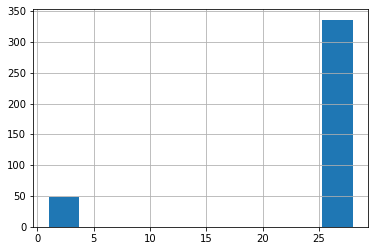

In [10]:
# How many unique perturbations per well
(
    df_level4
    .groupby(["Metadata_Well", "pert_iname"])["Metadata_broad_sample"]
    .nunique()
    .reset_index()
    .Metadata_Well
    .value_counts()
    .hist()
)

## Process null distribution per well

In [ ]:
full_well_null_distribution_of_scores = {}
did_not_pass_info = {}
for well in df_level4.Metadata_Well.unique():
    # Print for progress
    print(f"Now processing well: {well}")

    # Subset the profiles to only one specific well
    level4_well_subset_df = df_level4.query("Metadata_Well == @well")
    
    # Make sure there are enough different samples
    num_unique_samples = level4_well_subset_df.pert_iname.nunique()
    if num_unique_samples <= num_unique_sample_cutoff:
        did_not_pass_info[well] = {"num_unique_samples": num_unique_samples}
        continue

    # Define the replicate cardinalities
    replicate_cardinalities = level4_well_subset_df.pert_iname.value_counts().unique()

    # Remove replicate cardinality of 1
    replicate_cardinalities = np.array([x for x in replicate_cardinalities if x >=2])
    
    # Define a null distribution
    null_distrib_replicates = get_null_distribution_replicates(
        well_df=level4_well_subset_df,
        cardinalities=replicate_cardinalities,
        rand_num=random_permutation_count
    )
    
    # Get null distribution median scores
    median_scores_per_well = get_null_dist_median_scores(
        well_df=level4_well_subset_df,
        null_distribution=null_distrib_replicates,
        metadata_cols_to_drop=metadata_cols_to_drop
    )
    
    # Save null distribution per well
    full_well_null_distribution_of_scores[well] = median_scores_per_well

Now processing well: A01
Now processing well: A02
Now processing well: A03
Now processing well: A04
Now processing well: A05
Now processing well: A06
Now processing well: B01
Now processing well: B02
Now processing well: B03
Now processing well: B04
Now processing well: B05
Now processing well: B06
Now processing well: F07
Now processing well: F08
Now processing well: F09
Now processing well: F10
Now processing well: F11
Now processing well: F12
Now processing well: J13
Now processing well: J14
Now processing well: J15
Now processing well: J16
Now processing well: J17
Now processing well: J18
Now processing well: A07
Now processing well: A08
Now processing well: A09
Now processing well: A10
Now processing well: A11
Now processing well: A12
Now processing well: A13
Now processing well: A14
Now processing well: A15
Now processing well: A16
Now processing well: A17
Now processing well: A18
Now processing well: A19
Now processing well: A20
Now processing well: A21
Now processing well: A22


## Calculate non-parametric p value

In [ ]:
non_parametric_p_vals = []
for idx, treatment in df_cpd_med_scores_melt.iterrows():
    compound = treatment.compound
    cardinality = treatment.no_of_replicates
    
    if cardinality == 1:
        continue
        
    well = treatment.Metadata_Well
    dose = treatment.dose_recode
    score = treatment.median_score
    
    # Pull appropriate null distribution:
    null_dist = full_well_null_distribution_of_scores[well][cardinality]
    
    # Calculate p value
    p_value = np.sum(np.less(score, null_dist)) / len(null_dist)
    
    # Save results
    results = [
        compound,
        cardinality,
        well,
        dose,
        score,
        p_value
    ]
    
    # Add to list
    non_parametric_p_vals.append(results)
    
# Get full results
pval_df = pd.DataFrame(
    non_parametric_p_vals,
    columns=[
        "compound",
        "no_of_compounds",
        "well",
        "dose_recode",
        "median_score",
        "p_value"
    ]
)

# Save to file
pval_df.to_csv(output_file, index=False, sep="\t")

print(pval_df.shape)
pval_df.head()